In [1]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.notebook import tqdm
import torchmetrics
import cv2
device0 = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

dataload

In [2]:
#fit
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform_30/train/'
test_csv_path ='../../data/AF/Waveform_30/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,750)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,750)
test_label=torch.empty(len(test_data_list),1)
for i in range(len(train_data_list)):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    train_data[i]=torch.tensor(resized(signal_csv,750))
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in range(len(test_data_list)):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(resized(signal_csv,750))
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model

In [3]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(1500, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,1,750))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [256, 1]                  --
├─Conv1d: 1-1                            [256, 50, 750]            200
├─ReLU: 1-2                              [256, 50, 750]            --
├─Dropout1d: 1-3                         [256, 50, 750]            --
├─MaxPool1d: 1-4                         [256, 50, 150]            --
├─Conv1d: 1-5                            [256, 50, 150]            7,550
├─ReLU: 1-6                              [256, 50, 150]            --
├─Dropout1d: 1-7                         [256, 50, 150]            --
├─MaxPool1d: 1-8                         [256, 50, 30]             --
├─Linear: 1-9                            [256, 200]                300,000
├─Linear: 1-10                           [256, 1]                  200
Total params: 307,950
Trainable params: 307,950
Non-trainable params: 0
Total mult-adds (M): 405.17
Input size (MB): 0.77
Forward/backward pass s

Train

epoch: 1/1000 train_loss : 0.7020 train_accuracy: 0.5310 val_loss : 0.6821  val_accuracy: 0.5480
epoch: 2/1000 train_loss : 0.6662 train_accuracy: 0.5937 val_loss : 0.6442  val_accuracy: 0.5711


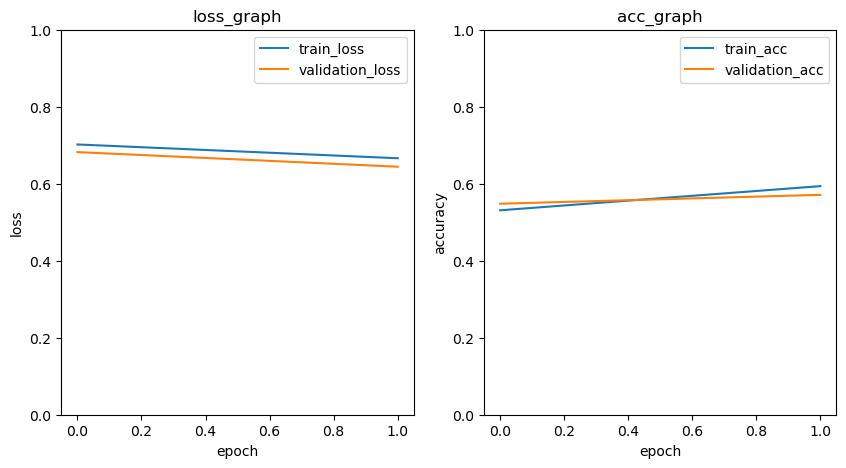

epoch: 3/1000 train_loss : 0.6435 train_accuracy: 0.6150 val_loss : 0.6320  val_accuracy: 0.5715
epoch: 4/1000 train_loss : 0.6293 train_accuracy: 0.6224 val_loss : 0.6244  val_accuracy: 0.5648
epoch: 5/1000 train_loss : 0.6158 train_accuracy: 0.6241 val_loss : 0.6146  val_accuracy: 0.5672
epoch: 6/1000 train_loss : 0.6006 train_accuracy: 0.6306 val_loss : 0.5938  val_accuracy: 0.5758
epoch: 7/1000 train_loss : 0.5931 train_accuracy: 0.6351 val_loss : 0.5875  val_accuracy: 0.5730
epoch: 8/1000 train_loss : 0.5776 train_accuracy: 0.6405 val_loss : 0.5847  val_accuracy: 0.5715
epoch: 9/1000 train_loss : 0.5693 train_accuracy: 0.6478 val_loss : 0.5887  val_accuracy: 0.5586
epoch: 10/1000 train_loss : 0.5580 train_accuracy: 0.6741 val_loss : 0.5505  val_accuracy: 0.6406
epoch: 11/1000 train_loss : 0.5368 train_accuracy: 0.6984 val_loss : 0.5007  val_accuracy: 0.7449
epoch: 12/1000 train_loss : 0.5187 train_accuracy: 0.7213 val_loss : 0.4801  val_accuracy: 0.7648
epoch: 13/1000 train_loss :

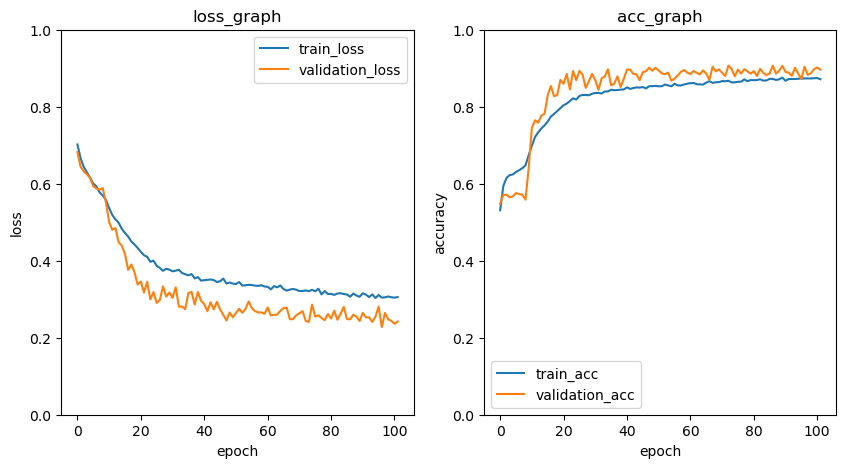

epoch: 103/1000 train_loss : 0.3000 train_accuracy: 0.8761 val_loss : 0.2761  val_accuracy: 0.8797
epoch: 104/1000 train_loss : 0.3035 train_accuracy: 0.8735 val_loss : 0.2510  val_accuracy: 0.8895
epoch: 105/1000 train_loss : 0.3106 train_accuracy: 0.8722 val_loss : 0.2336  val_accuracy: 0.9086
epoch: 106/1000 train_loss : 0.3050 train_accuracy: 0.8737 val_loss : 0.2537  val_accuracy: 0.8852
epoch: 107/1000 train_loss : 0.3057 train_accuracy: 0.8730 val_loss : 0.2139  val_accuracy: 0.9113
epoch: 108/1000 train_loss : 0.3032 train_accuracy: 0.8763 val_loss : 0.2352  val_accuracy: 0.8930
epoch: 109/1000 train_loss : 0.3030 train_accuracy: 0.8762 val_loss : 0.2287  val_accuracy: 0.9066
epoch: 110/1000 train_loss : 0.2965 train_accuracy: 0.8776 val_loss : 0.2237  val_accuracy: 0.9051
epoch: 111/1000 train_loss : 0.2997 train_accuracy: 0.8751 val_loss : 0.2334  val_accuracy: 0.8969
epoch: 112/1000 train_loss : 0.2981 train_accuracy: 0.8740 val_loss : 0.2440  val_accuracy: 0.9000
epoch: 113

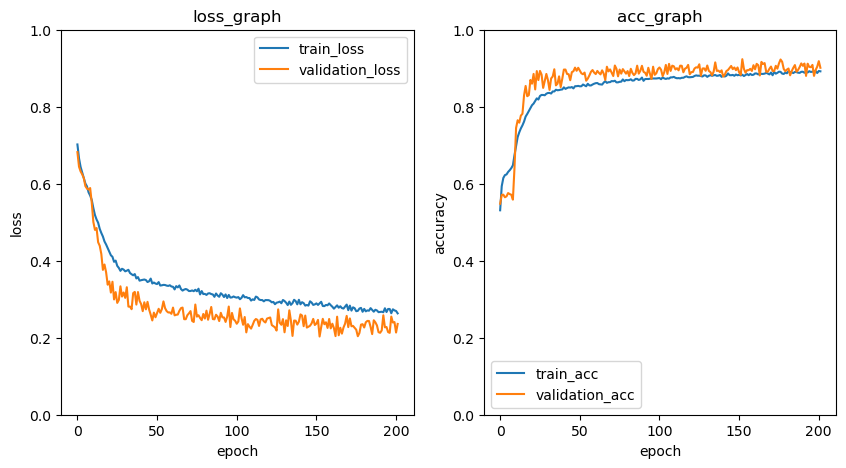

epoch: 203/1000 train_loss : 0.2753 train_accuracy: 0.8867 val_loss : 0.2147  val_accuracy: 0.9062
epoch: 204/1000 train_loss : 0.2622 train_accuracy: 0.8919 val_loss : 0.2229  val_accuracy: 0.8961
epoch: 205/1000 train_loss : 0.2721 train_accuracy: 0.8890 val_loss : 0.2079  val_accuracy: 0.9055
epoch: 206/1000 train_loss : 0.2698 train_accuracy: 0.8901 val_loss : 0.2360  val_accuracy: 0.8941
epoch: 207/1000 train_loss : 0.2615 train_accuracy: 0.8954 val_loss : 0.2224  val_accuracy: 0.8973
epoch: 208/1000 train_loss : 0.2700 train_accuracy: 0.8918 val_loss : 0.2198  val_accuracy: 0.9016
epoch: 209/1000 train_loss : 0.2616 train_accuracy: 0.8911 val_loss : 0.2232  val_accuracy: 0.8949
epoch: 210/1000 train_loss : 0.2695 train_accuracy: 0.8896 val_loss : 0.2078  val_accuracy: 0.9113
epoch: 211/1000 train_loss : 0.2584 train_accuracy: 0.8932 val_loss : 0.2175  val_accuracy: 0.9117
epoch: 212/1000 train_loss : 0.2634 train_accuracy: 0.8928 val_loss : 0.2058  val_accuracy: 0.9156
epoch: 213

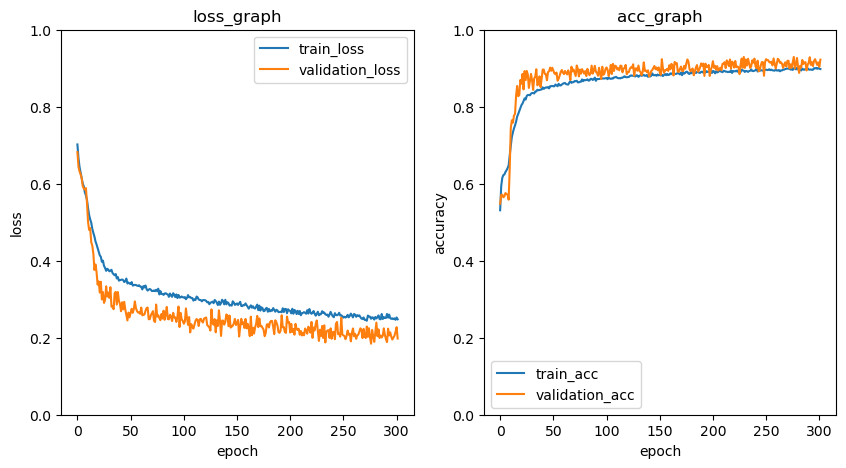

epoch: 303/1000 train_loss : 0.2508 train_accuracy: 0.8998 val_loss : 0.1891  val_accuracy: 0.9285
epoch: 304/1000 train_loss : 0.2556 train_accuracy: 0.8978 val_loss : 0.2108  val_accuracy: 0.9094
epoch: 305/1000 train_loss : 0.2458 train_accuracy: 0.8988 val_loss : 0.2136  val_accuracy: 0.9098
epoch: 306/1000 train_loss : 0.2505 train_accuracy: 0.8969 val_loss : 0.1956  val_accuracy: 0.9242
epoch: 307/1000 train_loss : 0.2529 train_accuracy: 0.8963 val_loss : 0.1959  val_accuracy: 0.9227
epoch: 308/1000 train_loss : 0.2541 train_accuracy: 0.8968 val_loss : 0.1874  val_accuracy: 0.9230
epoch: 309/1000 train_loss : 0.2492 train_accuracy: 0.8971 val_loss : 0.2077  val_accuracy: 0.9285
epoch: 310/1000 train_loss : 0.2525 train_accuracy: 0.8993 val_loss : 0.2107  val_accuracy: 0.9020
epoch: 311/1000 train_loss : 0.2571 train_accuracy: 0.8958 val_loss : 0.2130  val_accuracy: 0.9238
epoch: 312/1000 train_loss : 0.2468 train_accuracy: 0.8963 val_loss : 0.2105  val_accuracy: 0.9113
epoch: 313

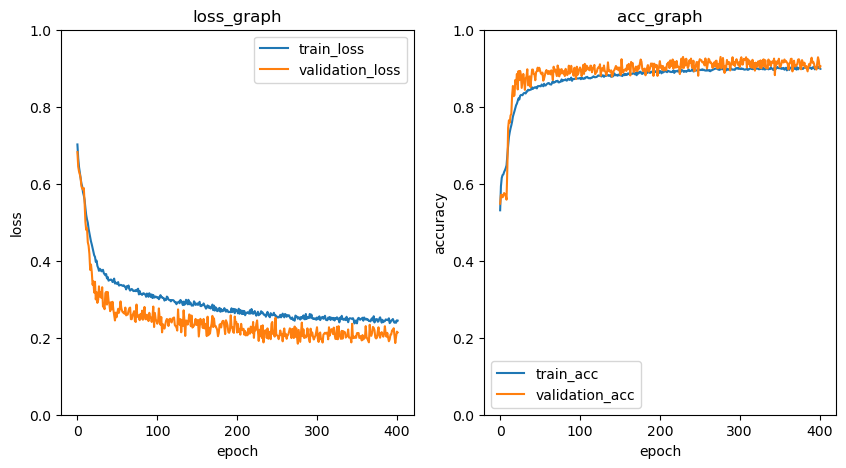

epoch: 403/1000 train_loss : 0.2438 train_accuracy: 0.9008 val_loss : 0.1969  val_accuracy: 0.9156
epoch: 404/1000 train_loss : 0.2453 train_accuracy: 0.9013 val_loss : 0.1996  val_accuracy: 0.9172
epoch: 405/1000 train_loss : 0.2417 train_accuracy: 0.9019 val_loss : 0.1882  val_accuracy: 0.9301
epoch: 406/1000 train_loss : 0.2440 train_accuracy: 0.9019 val_loss : 0.2171  val_accuracy: 0.9105
epoch: 407/1000 train_loss : 0.2406 train_accuracy: 0.9044 val_loss : 0.2117  val_accuracy: 0.9090
epoch: 408/1000 train_loss : 0.2389 train_accuracy: 0.9047 val_loss : 0.1980  val_accuracy: 0.9180
epoch: 409/1000 train_loss : 0.2407 train_accuracy: 0.9043 val_loss : 0.2157  val_accuracy: 0.9078
epoch: 410/1000 train_loss : 0.2433 train_accuracy: 0.9021 val_loss : 0.2023  val_accuracy: 0.9152
epoch: 411/1000 train_loss : 0.2421 train_accuracy: 0.9037 val_loss : 0.1774  val_accuracy: 0.9297
epoch: 412/1000 train_loss : 0.2389 train_accuracy: 0.9029 val_loss : 0.1863  val_accuracy: 0.9238
epoch: 413

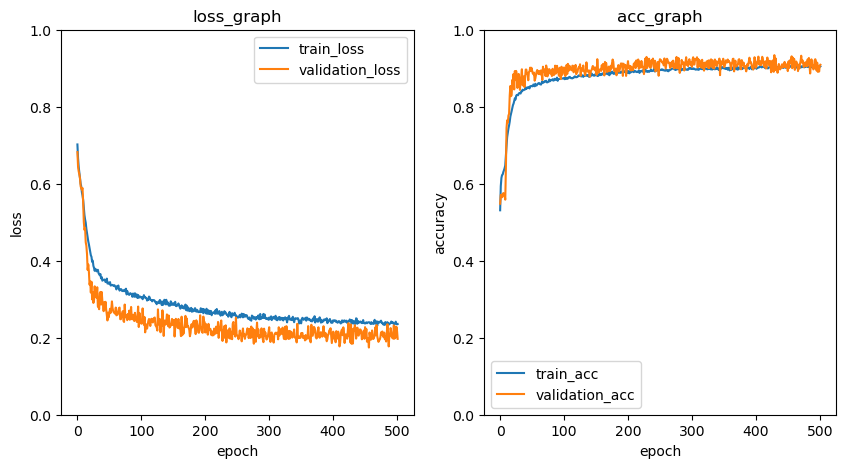

epoch: 503/1000 train_loss : 0.2324 train_accuracy: 0.9058 val_loss : 0.1902  val_accuracy: 0.9219
epoch: 504/1000 train_loss : 0.2390 train_accuracy: 0.9040 val_loss : 0.1875  val_accuracy: 0.9242
epoch: 505/1000 train_loss : 0.2311 train_accuracy: 0.9053 val_loss : 0.1927  val_accuracy: 0.9187
epoch: 506/1000 train_loss : 0.2314 train_accuracy: 0.9067 val_loss : 0.1945  val_accuracy: 0.9199
epoch: 507/1000 train_loss : 0.2364 train_accuracy: 0.9065 val_loss : 0.1969  val_accuracy: 0.9125
epoch: 508/1000 train_loss : 0.2371 train_accuracy: 0.9072 val_loss : 0.1984  val_accuracy: 0.9172
epoch: 509/1000 train_loss : 0.2367 train_accuracy: 0.9033 val_loss : 0.1970  val_accuracy: 0.9219
epoch: 510/1000 train_loss : 0.2361 train_accuracy: 0.9077 val_loss : 0.2099  val_accuracy: 0.9109
epoch: 511/1000 train_loss : 0.2378 train_accuracy: 0.9062 val_loss : 0.2247  val_accuracy: 0.8992
epoch: 512/1000 train_loss : 0.2365 train_accuracy: 0.9058 val_loss : 0.2014  val_accuracy: 0.9203
epoch: 513

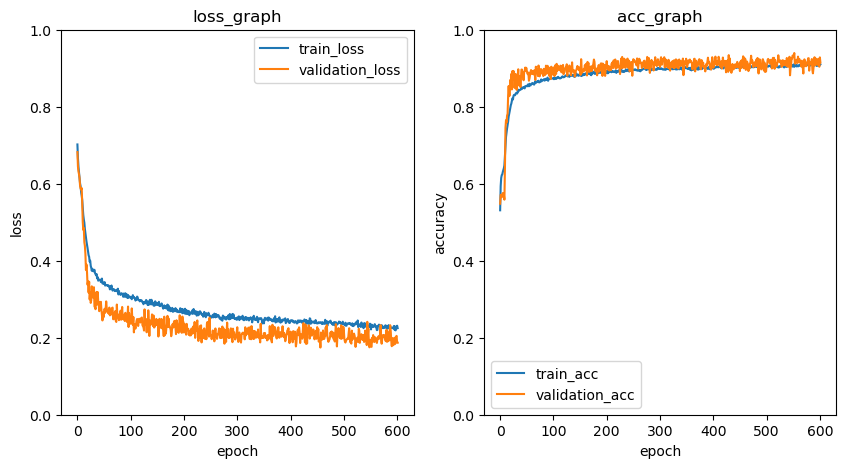

epoch: 603/1000 train_loss : 0.2250 train_accuracy: 0.9074 val_loss : 0.1942  val_accuracy: 0.9164
epoch: 604/1000 train_loss : 0.2269 train_accuracy: 0.9073 val_loss : 0.2031  val_accuracy: 0.9070
epoch: 605/1000 train_loss : 0.2263 train_accuracy: 0.9080 val_loss : 0.2079  val_accuracy: 0.9102
epoch: 606/1000 train_loss : 0.2300 train_accuracy: 0.9089 val_loss : 0.1904  val_accuracy: 0.9172
epoch: 607/1000 train_loss : 0.2295 train_accuracy: 0.9082 val_loss : 0.1959  val_accuracy: 0.9121
epoch: 608/1000 train_loss : 0.2208 train_accuracy: 0.9093 val_loss : 0.2073  val_accuracy: 0.9008
epoch: 609/1000 train_loss : 0.2287 train_accuracy: 0.9085 val_loss : 0.1844  val_accuracy: 0.9195
epoch: 610/1000 train_loss : 0.2244 train_accuracy: 0.9112 val_loss : 0.1952  val_accuracy: 0.9141
epoch: 611/1000 train_loss : 0.2257 train_accuracy: 0.9092 val_loss : 0.2333  val_accuracy: 0.8898
epoch: 612/1000 train_loss : 0.2226 train_accuracy: 0.9103 val_loss : 0.2084  val_accuracy: 0.8996
epoch: 613

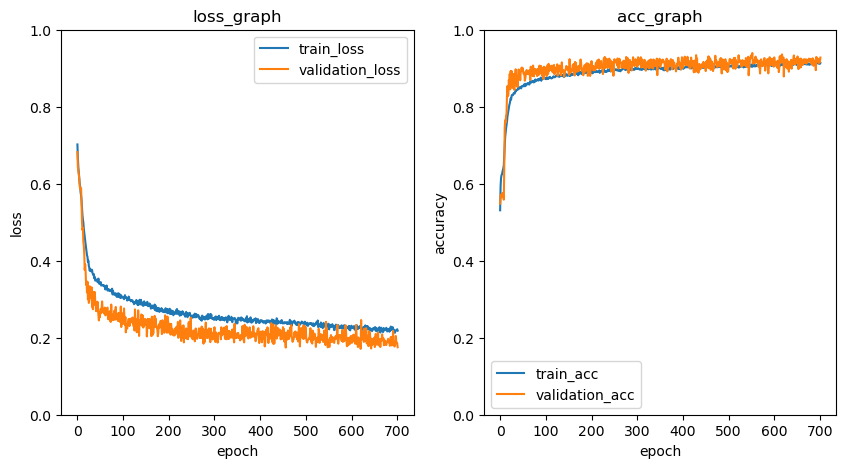

epoch: 703/1000 train_loss : 0.2180 train_accuracy: 0.9126 val_loss : 0.1776  val_accuracy: 0.9230
epoch: 704/1000 train_loss : 0.2199 train_accuracy: 0.9102 val_loss : 0.2007  val_accuracy: 0.9090
epoch: 705/1000 train_loss : 0.2257 train_accuracy: 0.9092 val_loss : 0.1835  val_accuracy: 0.9168
epoch: 706/1000 train_loss : 0.2180 train_accuracy: 0.9107 val_loss : 0.2080  val_accuracy: 0.9055
epoch: 707/1000 train_loss : 0.2199 train_accuracy: 0.9114 val_loss : 0.1862  val_accuracy: 0.9172
epoch: 708/1000 train_loss : 0.2210 train_accuracy: 0.9119 val_loss : 0.1978  val_accuracy: 0.9137
epoch: 709/1000 train_loss : 0.2179 train_accuracy: 0.9115 val_loss : 0.1829  val_accuracy: 0.9168
epoch: 710/1000 train_loss : 0.2227 train_accuracy: 0.9105 val_loss : 0.1827  val_accuracy: 0.9109
epoch: 711/1000 train_loss : 0.2239 train_accuracy: 0.9085 val_loss : 0.2008  val_accuracy: 0.9109
epoch: 712/1000 train_loss : 0.2176 train_accuracy: 0.9131 val_loss : 0.1692  val_accuracy: 0.9313
epoch: 713

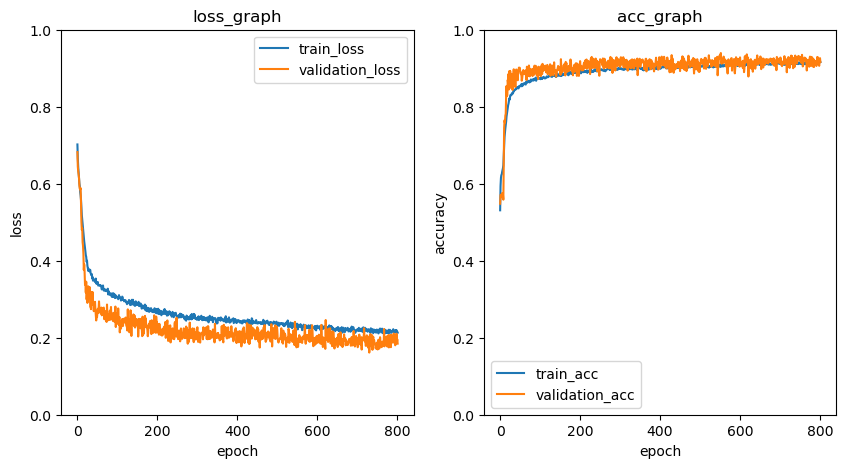

epoch: 803/1000 train_loss : 0.2125 train_accuracy: 0.9166 val_loss : 0.2145  val_accuracy: 0.9039
epoch: 804/1000 train_loss : 0.2135 train_accuracy: 0.9145 val_loss : 0.1845  val_accuracy: 0.9215
epoch: 805/1000 train_loss : 0.2096 train_accuracy: 0.9146 val_loss : 0.1881  val_accuracy: 0.9121
epoch: 806/1000 train_loss : 0.2166 train_accuracy: 0.9160 val_loss : 0.1891  val_accuracy: 0.9207
epoch: 807/1000 train_loss : 0.2113 train_accuracy: 0.9152 val_loss : 0.1908  val_accuracy: 0.9160
epoch: 808/1000 train_loss : 0.2152 train_accuracy: 0.9142 val_loss : 0.2002  val_accuracy: 0.9078
epoch: 809/1000 train_loss : 0.2200 train_accuracy: 0.9139 val_loss : 0.1717  val_accuracy: 0.9285
epoch: 810/1000 train_loss : 0.2172 train_accuracy: 0.9152 val_loss : 0.1803  val_accuracy: 0.9211
epoch: 811/1000 train_loss : 0.2198 train_accuracy: 0.9136 val_loss : 0.1770  val_accuracy: 0.9289
epoch: 812/1000 train_loss : 0.2098 train_accuracy: 0.9169 val_loss : 0.1862  val_accuracy: 0.9160
epoch: 813

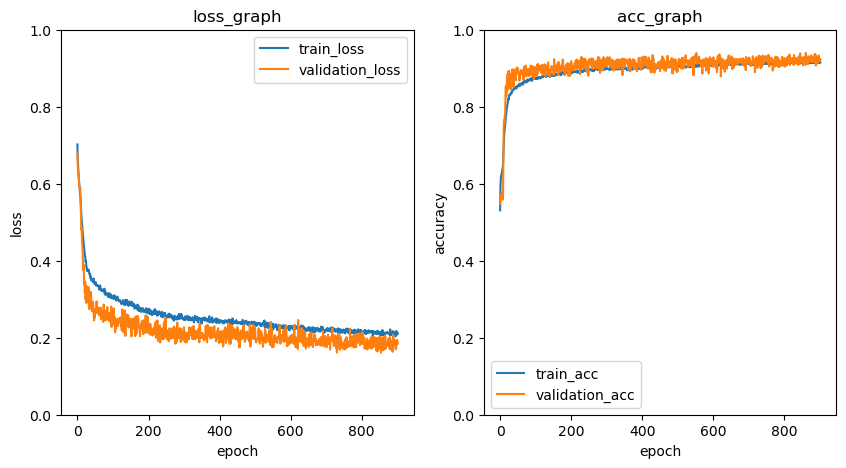

epoch: 903/1000 train_loss : 0.2145 train_accuracy: 0.9150 val_loss : 0.1872  val_accuracy: 0.9258
epoch: 904/1000 train_loss : 0.2140 train_accuracy: 0.9153 val_loss : 0.1813  val_accuracy: 0.9176
epoch: 905/1000 train_loss : 0.2091 train_accuracy: 0.9177 val_loss : 0.1838  val_accuracy: 0.9152
epoch: 906/1000 train_loss : 0.2106 train_accuracy: 0.9144 val_loss : 0.1910  val_accuracy: 0.9164
epoch: 907/1000 train_loss : 0.2093 train_accuracy: 0.9147 val_loss : 0.2001  val_accuracy: 0.9137
epoch: 908/1000 train_loss : 0.2084 train_accuracy: 0.9173 val_loss : 0.1633  val_accuracy: 0.9352
epoch: 909/1000 train_loss : 0.2061 train_accuracy: 0.9170 val_loss : 0.2120  val_accuracy: 0.9105
epoch: 910/1000 train_loss : 0.2115 train_accuracy: 0.9161 val_loss : 0.1839  val_accuracy: 0.9242
epoch: 911/1000 train_loss : 0.2065 train_accuracy: 0.9162 val_loss : 0.1643  val_accuracy: 0.9305
epoch: 912/1000 train_loss : 0.2118 train_accuracy: 0.9142 val_loss : 0.1889  val_accuracy: 0.9191
epoch: 913

In [4]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_30_25hz_TypeAll_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_30_25hz_TypeAll.pt')

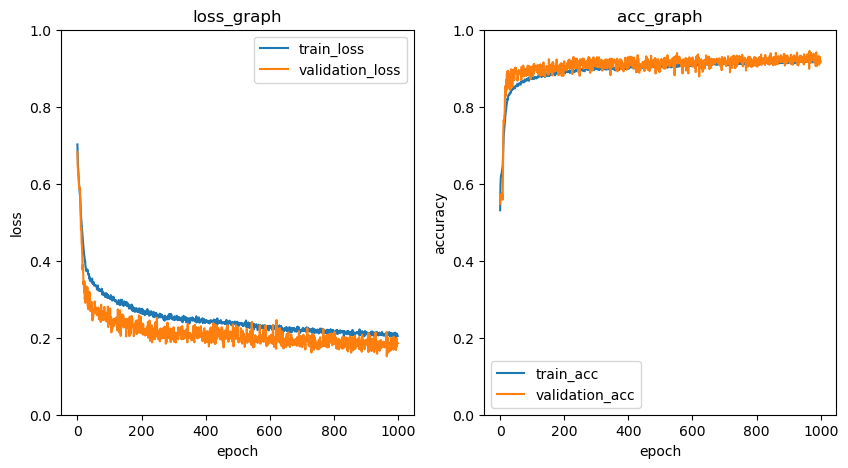

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()